In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [6]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))



Aux function for splitting between training and testing


In [7]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [9]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def leaves(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def wood(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def pole(input, target):
    target = target.squeeze(1)
    mask = target != 3
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def grape(input, target):
    target = target.squeeze(1)
    mask = target != 4
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Early Stopping parameters

In [10]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=3

In [11]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [12]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [13]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=4
        mask[mask==150]=1
        mask[mask==76]=3
        mask[mask==74]=3
        mask[mask==29]=2
        mask[mask==25]=2
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [14]:
path_manual_img = path_images/'trainSemi'
path_manual_lbl = path_labels/'trainSemi'

dataset/Images/trainSemi/color00125.jpg


<AxesSubplot:>

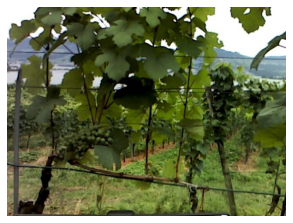

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

dataset/Labels/trainSemi/gt00125.png


<AxesSubplot:>

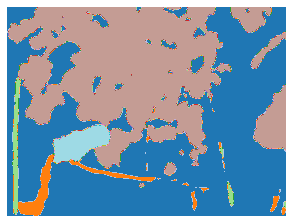

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
for p in lbl_names_manual:
    mask = PILMask.create(get_y_fn(p))
    if(len(np.unique(np.array(mask)))>5):
        print(p)

dataset/Labels/trainSemi/gt_205.png
dataset/Labels/trainSemi/gt_102.png
dataset/Labels/trainSemi/gt_104.png
dataset/Labels/trainSemi/gt_218.png
dataset/Labels/trainSemi/gt_103.png
dataset/Labels/trainSemi/gt_41.png


In [19]:
bs = 4

In [20]:
codes

array(['Background', 'Leaves', 'Wood', 'Pole', 'Grape'], dtype='<U10')

In [21]:
def my_get_items(folders,path):
    return (get_image_files(path))

In [22]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['trainSemi','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
#dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [23]:
#x,mask=dls.one_batch()

# Unet

In [24]:
learn = get_segmentation_learner(dls=dls, number_classes=5, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[background,leaves,pole,grape,wood,msa],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

In [25]:
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,0.511237,0.585237,0.870368,0.688491,0.813363,0.811229,0.809223,0.801793,00:39
1,0.268726,0.460791,0.841262,0.803302,0.854842,0.851546,0.858188,0.846530,00:41
2,0.201093,0.492673,0.888291,0.745226,0.834771,0.835443,0.839454,0.830514,00:41
3,0.166563,0.484426,0.874983,0.776719,0.847041,0.847223,0.851914,0.842336,00:42


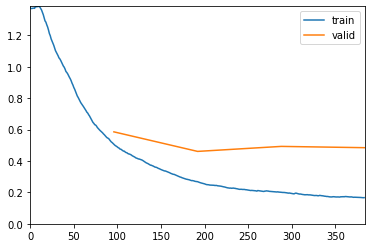

Better model found at epoch 0 with valid_loss value: 0.5852373838424683.
Better model found at epoch 1 with valid_loss value: 0.4607914090156555.


/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [26]:
fname="unet-before-unfreeze"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(4, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

In [27]:
learn.load("unet-before-unfreeze")
learn.unfreeze()
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,0.198438,0.463924,0.828579,0.815209,0.856175,0.853408,0.859710,0.847841,00:40
1,0.185638,0.465232,0.847060,0.798019,0.853160,0.850223,0.856110,0.845255,00:41
2,0.187249,0.467950,0.852795,0.790473,0.851541,0.848744,0.854433,0.843710,00:39
3,0.182584,0.460049,0.843961,0.803569,0.854104,0.851768,0.857776,0.846681,00:35
4,0.183165,0.471397,0.857308,0.784717,0.850195,0.847406,0.852884,0.842396,00:37


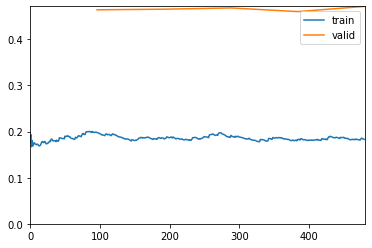

Better model found at epoch 0 with valid_loss value: 0.46392399072647095.
Better model found at epoch 3 with valid_loss value: 0.4600488841533661.


In [28]:
fname="unet-after-unfreeze"


callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(5, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

In [29]:
#learn.load("unet-before-unfreeze")

learn.validate()

(#7) [0.4600488841533661,0.8439606428146362,0.8035688996315002,0.8541035652160645,0.8517681360244751,0.8577758073806763,0.8466811180114746]

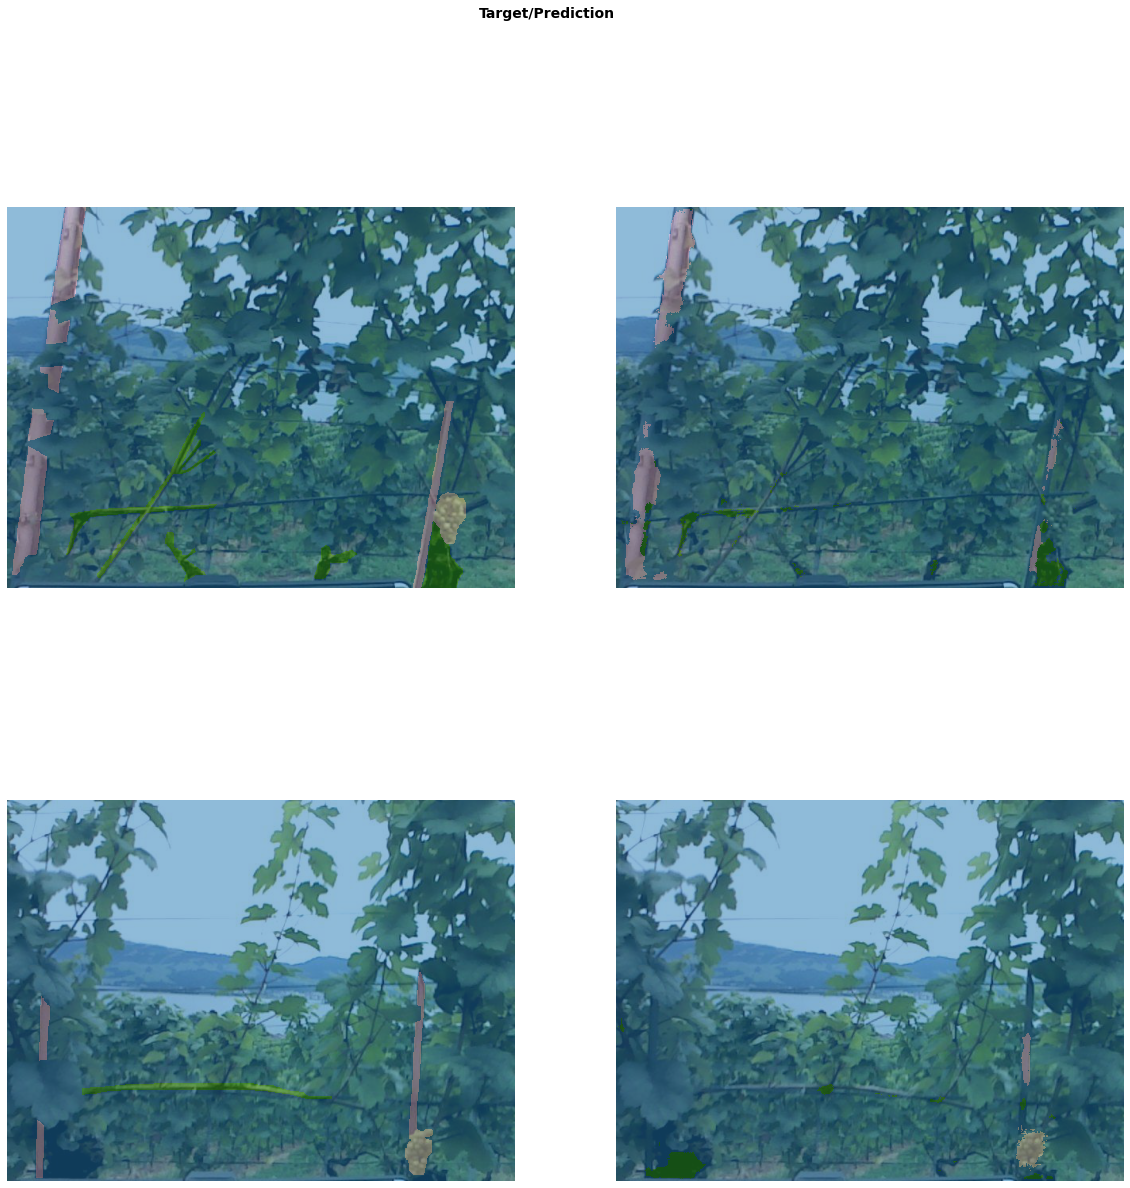

In [30]:
learn.show_results(figsize=(20,20))

In [32]:
aux=learn.model
aux=aux.cpu()

import torchvision.transforms as transforms
img = PILImage.create("dataset/Images/train/color_38.jpg")
transformer=transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("unet-pseudolabel.pth")

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/vision/models/unet.py:37: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/vision/models/unet.py:47: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.orig.shape[-2:] != x.shape[-2:]:
